In [1]:
# Instalando conda (mamba)
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [2]:
# Instalando pacotes necessários
!mamba install -c conda-forge cartopy siphon metpy imgaug
!apt-get -qq install libproj-dev libgeos-dev
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install pyyaml==5.4.1


Looking for: ['cartopy', 'siphon', 'metpy', 'imgaug']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   1%
conda-forge/noarch     4%[+] 0.3s
conda-forge/linux-64   7%
conda-forge/noarch    26%[+] 0.4s
conda-forge/linux-64  16%
conda-forge/noarch    44%[+] 0.5s
conda-forge/linux-64  21%
conda-forge/noarch    63%[+] 0.6s
conda-forge/linux-64  25%
conda-forge/noarch    74%[+] 0.7s
conda-forge/linux-64  30%
conda-forge/noarch    74%[+] 0.8s
conda-forge/linux-64  30%
conda-forge/noarch    74%[+] 0.9s
conda-forge/linux-64  35%
conda-forge/noarch    84%[+] 1.0s
conda-forge/linux-64  35%
conda-forge/noarch    95%[+] 1.1s
conda-forge/linux-64  39%
conda-forge/noarch   100%conda-forge/noarch                                
[+] 1.2s
conda-forge/linux-64  44%[+] 1.3s
conda-forge/linux-64  49%[+] 1.4s
conda-forge/linux-64  58%[+] 1.5s
conda-forge/linux-64  67%[+] 1.6s
conda-forge/linux-64  72%[+] 1.7s
conda-forge/linux-64  86%[+] 1.8s
conda-forge

In [1]:
# A whole bunch of imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import num2date
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
from datetime import datetime
import numpy as np
import numpy.ma as ma
from metpy.io import GiniFile
from metpy.plots.ctables import registry
from metpy.units import units
import metpy.calc as mpcalc

In [2]:
dt = datetime(2024, 6, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_onedeg_ana/GFS_Global_onedeg_ana_'
#cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
base_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg_ana/GFS_Global_0p25deg_ana_'
cat = TDSCatalog(f'{base_url}{dt:%Y%m%d}_{dt:%H}00.grib2/catalog.xml')
ncss = cat.datasets[0].subset()

# Setando
nivel_vento = 925
nivel_omega = 500
lat_sul = -67.5 #-30
lat_norte = 30
lon_leste = 360
lon_oeste = 230
lon_l = lon_leste - 360
lon_o = lon_oeste - 360

# First get wind components data
query_wind = ncss.query()
query_wind.variables('u-component_of_wind_isobaric',
                     'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
query_wind.vertical_level(nivel_vento * 100)
query_wind.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_wind = ncss.get_data(query_wind)

# Get Precipitable Water
query_prtwt = ncss.query()
query_prtwt.variables('Precipitable_water_entire_atmosphere_single_layer').add_lonlat().accept('netcdf')
query_prtwt.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_prtwt = ncss.get_data(query_prtwt)

# Get omega
query_omega = ncss.query()
query_omega.variables('Vertical_velocity_pressure_isobaric').add_lonlat().accept('netcdf')
query_omega.vertical_level(nivel_omega * 100)
query_omega.lonlat_box(north=lat_norte, south=lat_sul, east=lon_leste, west=lon_oeste)
data_omega = ncss.get_data(query_omega)

In [3]:
# Tem que fazer esta alteração para conseguir plotar o vento
lon =  data_wind.variables['longitude'][:]
for i in range(len(lon)):
    if lon[i]>180:
        lon[i] = lon[i]-360

In [4]:
prtwt = data_prtwt.variables['Precipitable_water_entire_atmosphere_single_layer'][:].squeeze()

uwnd_nivel = data_wind.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd_nivel = data_wind.variables['v-component_of_wind_isobaric'][:].squeeze()
omega_nivel = data_omega.variables['Vertical_velocity_pressure_isobaric'][:].squeeze()

U_nivel = units('m/s') * ndimage.gaussian_filter(uwnd_nivel, sigma=1, order=0)
V_nivel = units('m/s') * ndimage.gaussian_filter(vwnd_nivel, sigma=1, order=0)
W_nivel = units('Pa/s') * ndimage.gaussian_filter(omega_nivel, sigma=1, order=0)

#lon = data_hght.variables['lon'][:]
lat = data_prtwt.variables['latitude'][:]
time = data_prtwt.variables[data_prtwt.variables['Precipitable_water_entire_atmosphere_single_layer'].dimensions[0]]
vtime = num2date(time[:], time.units)

In [5]:
#Quero somente os valores negativos de omega
mask_omega = ma.masked_greater_equal(W_nivel, 0).mask
W_nivel[mask_omega] = np.nan

/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


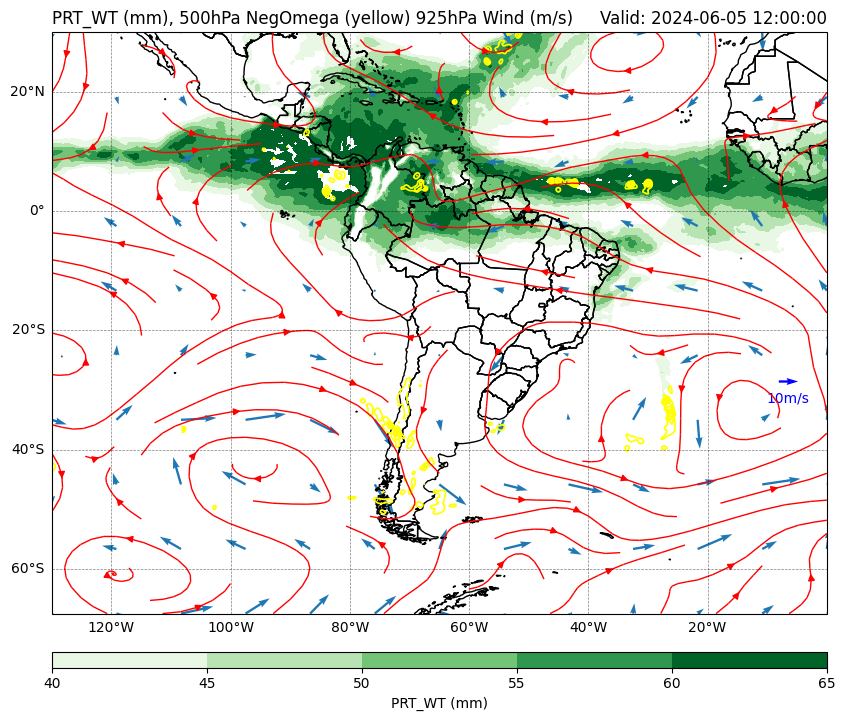

In [6]:
# Create the figure
datacrs = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=datacrs)

# Add mapping information
# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)
# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                                               name='admin_0_countries',
                                               scale='50m', facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)
ax.set_extent([lon_o, lon_l, lat_sul, lat_norte], ccrs.PlateCarree())

# Plotando agua precipitavel acima de 40 mm
clevppt = np.arange(40, 70, 5)
cs2 = ax.contourf(lon, lat,prtwt,clevppt,cmap = 'Greens')
cb = plt.colorbar(cs2,label='PRT_WT (mm)',orientation="horizontal", pad=0.05,aspect=50)

#Plotando omega negativo
cs = ax.contour(lon, lat,W_nivel*1e4, colors='yellow', linewidths=1.25,linestyles='solid',transform=ccrs.PlateCarree())

uv = ax.quiver(lon, lat, U_nivel, V_nivel, color='tab:blue',regrid_shape=10,
          width=0.003, scale = 400, transform=ccrs.PlateCarree())
#Draw the wind field, and after the arrow shaft, you have to explain the relationship between the length of the shaft and the wind speed
#Calling quiver can generate reference arrow + label.
ax.quiverkey(uv,                     #Incoming quiver handle
             X=0.95, Y = 0.4,       #Determine the location of label, all limited to [0,1]
             U = 10,                    #Reference arrow length means the wind speed is 5m/s.
             angle = 0,            #Reference arrow placement angle. The default is 0, which means horizontal placement
             label='10m/s',        #Arrow's supplement: label's content +
             labelpos='S',          #label is in which direction of the reference arrow; S means south
             color = 'b',labelcolor = 'b', #Arrow color + label color
             )
ax.streamplot(lon, lat, U_nivel, V_nivel, density=[0.5, 1],color='red', linewidth=1, cmap='autumn')
ax.set_title(f'PRT_WT (mm), 500hPa NegOmega (yellow) {nivel_vento}hPa Wind (m/s)', loc='left')
ax.set_title('Valid: {}'.format(vtime[0]), loc='right')

# Adding grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.left_labels = True
gl.right_labels = False
gl.xlines = True

# Salva o grafico no disco
plt.savefig("ZCIT_LC925_PrtWt_Om500.png", dpi=600, bbox_inches="tight")

##